In [0]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-02-07 06:36:24--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   185MB/s    in 3.5s    

2020-02-07 06:36:28 (178 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [0]:
!unzip multi_cased_L-12_H-768_A-12.zip -d bert_m

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: bert_m/multi_cased_L-12_H-768_A-12/
  inflating: bert_m/multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: bert_m/multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: bert_m/multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: bert_m/multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: bert_m/multi_cased_L-12_H-768_A-12/bert_config.json  


In [0]:
path = "bert_m/multi_cased_L-12_H-768_A-12"

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

Using TensorFlow backend.


In [0]:
import warnings
import os
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
!pip install keras-bert
!pip install keras-radam

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
import os
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [0]:
path = "/content/gdrive/My Drive/NLP"
data = pd.read_csv(path+ "/academy_squad_data.csv", encoding="utf8")

In [0]:
os.listdir(path)

['nltk_basic',
 'spam.csv',
 '03_케라스로_버트_빠르게_돌려보기_With_네이버_영화_감성분석_TUTORIAL.ipynb의 사본',
 'Untitled0.ipynb',
 'korquad_wordpiece_3.h5',
 'lecture.csv',
 'spam-test.ipynb',
 'academy_squad_data.csv',
 'squad-test.ipynb']

In [0]:
data

,question,context,text,answer_start,c_id
0,금융데이터 딥러닝 수강대상이 어떻게 되나요?,"파이썬을 활용한 금융 데이터,딥러닝을 만나다 수업 정보 입니다. \n본 강의의 목적...",Python 기본 문법과 금융 데이터 분석을 시작하고 싶으신 분,1661,0
1,금융 딥러닝 선생님이 누군가요?,"파이썬을 활용한 금융 데이터,딥러닝을 만나다 수업 정보 입니다. \n본 강의의 목적...",강사 김용범 약력은\n[GitHub 링크] [GitBlog링크] saltman2...,1466,0
2,금융 딥러닝 강사님 누군가요?,"파이썬을 활용한 금융 데이터,딥러닝을 만나다 수업 정보 입니다. \n본 강의의 목적...",강사 김용범 약력은\n[GitHub 링크] [GitBlog링크] saltman2...,1466,0
3,금융 딥러닝 강의 커리큘럼 알려주세요,"파이썬을 활용한 금융 데이터,딥러닝을 만나다 수업 정보 입니다. \n본 강의의 목적...",강의목차는 (jupyter notebook)\n\n1 파이썬 기초 및 Data & ...,594,0
4,금융 딥러닝에서 판다스(pandas) 배우나요?,"파이썬을 활용한 금융 데이터,딥러닝을 만나다 수업 정보 입니다. \n본 강의의 목적...","과정상세\n\n금융데이터 분석수업을 진행하면서 다양한 모듈과, 새로운 버젼이 제공될...",893,0
...,...,...,...,...,...
184,"파이썬 쌩초보, 캐글에 입문하다 수업시간이 어떻게 돼?","파이썬 쌩초보, 캐글에 입문하다.\n좋은 기회 !\n미루고 미루던 파이썬, 이번에 ...",2월 7~9일 (수목금) 총 5일 15시간,615,3
185,"파이썬 쌩초보, 캐글에 입문하다 수강료가 얼만데","파이썬 쌩초보, 캐글에 입문하다.\n좋은 기회 !\n미루고 미루던 파이썬, 이번에 ...",12만원,608,3
186,"파이썬 쌩초보, 캐글에 입문하다 강의시간?","파이썬 쌩초보, 캐글에 입문하다.\n좋은 기회 !\n미루고 미루던 파이썬, 이번에 ...",2월 7~9일 (수목금) 총 5일 15시간,615,3
187,"파이썬 쌩초보, 캐글에 입문하다 강사 정보는?","파이썬 쌩초보, 캐글에 입문하다.\n좋은 기회 !\n미루고 미루던 파이썬, 이번에 ...",한국인공지능협회 AI 아카데미,1025,3


In [0]:
SEQ_LEN = 384
BATCH_SIZE = 10
EPOCHS=2
LR=3e-5

pretrained_path = "/content/bert_m/multi_cased_L-12_H-768_A-12/"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "context"
QUESTION_COLUMN = "question"
TEXT = "text"

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

In [0]:
print(tokenizer.tokenize("한국어 토큰화"), tokenizer.tokenize("토큰화 해봐"))

['[CLS]', '한국', '##어', '토', '##큰', '##화', '[SEP]'] ['[CLS]', '토', '##큰', '##화', '해', '##봐', '[SEP]']


In [0]:
token_dict

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

In [0]:
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [0]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused1]',
 2: '[unused2]',
 3: '[unused3]',
 4: '[unused4]',
 5: '[unused5]',
 6: '[unused6]',
 7: '[unused7]',
 8: '[unused8]',
 9: '[unused9]',
 10: '[unused10]',
 11: '[unused11]',
 12: '[unused12]',
 13: '[unused13]',
 14: '[unused14]',
 15: '[unused15]',
 16: '[unused16]',
 17: '[unused17]',
 18: '[unused18]',
 19: '[unused19]',
 20: '[unused20]',
 21: '[unused21]',
 22: '[unused22]',
 23: '[unused23]',
 24: '[unused24]',
 25: '[unused25]',
 26: '[unused26]',
 27: '[unused27]',
 28: '[unused28]',
 29: '[unused29]',
 30: '[unused30]',
 31: '[unused31]',
 32: '[unused32]',
 33: '[unused33]',
 34: '[unused34]',
 35: '[unused35]',
 36: '[unused36]',
 37: '[unused37]',
 38: '[unused38]',
 39: '[unused39]',
 40: '[unused40]',
 41: '[unused41]',
 42: '[unused42]',
 43: '[unused43]',
 44: '[unused44]',
 45: '[unused45]',
 46: '[unused46]',
 47: '[unused47]',
 48: '[unused48]',
 49: '[unused49]',
 50: '[unused50]',
 51: '[unused51]',
 52: '[unused52]',
 53: '[unused53]'

In [0]:
question = data['question'][0]
context = data['context'][0]
text = data['text'][0]

In [0]:
question

'금융데이터 딥러닝 수강대상이 어떻게 되나요?'

In [0]:
context

"파이썬을 활용한 금융 데이터,딥러닝을 만나다 수업 정보 입니다. \n본 강의의 목적은 공개 오픈소스 툴인 파이썬 언어의 기초를 익히고, 이를 활용하여 Pandas 모듈을 활용하여 다양한 금융 기술적 분석 능력을 스스로 갖출 수 있도록 실습과 이론을 통하여 배울 수 있도록 진행합니다. 이러한 바탕위에 'hmmlearm', 'statemodel', 'prophet', 'keras' 모듈에 어떤 방식으로 응용 확장을 학습 함으로써 본 강의를 통해서 수강생들이 단순한 실습만 아니라 실제적으로 각자의 업무에 어떻게 적용하는지에 대한 실무적 아이디어를 얻어 가실 수 있습니다.\n수강대상은\n시계열 데이터를 다루기 원하시는 분\nPython의 기본 원리와 문법 내용을 정리하고, 이를 바탕으로 Pandas 모듈을 활용한 시계열 데이터를 다루는 방법을 진행합니다\n금융 Simulation을 구현하기 원하는 분 \n독자적 투자기술과 이론에 대한 실습을 다루는 내용을 진행합니다\n머신러닝 이론을 적용해 보고 싶은 분 \nPandas로 생성한 DataFrame 데이터를 바탕으로, 기본적인 금융분석 내용과 머신러닝 이론 활용한 금융데이터 방향성을 분석 및 예측하는 과정을 진행합니다\n\n강의목차는 (jupyter notebook)\n\n1 파이썬 기초 및 Data & Datum \n[링크] Jupyter Notebook \n2 문자열 데이터와 사용자 함수 기초\n[링크] Jupyter Notebook \n3 Pandas 모듈의 기본\n[링크] Jupyter Notebook \n4 Pandas 로 시계열 데이터 다루기\n[링크] Jupyter Notebook \n5 Pandas 활용한 금융데이터 분석\n[링크] Jupyter Notebook \n6 머신러닝 기본 모듈을 활용한 금융데이터 분석\n[링크] Jupyter Notebook \n\n과정상세\n\n금융데이터 분석수업을 진행하면서 다양한 모듈과, 새로운 버젼이 제공될때마다 관련 코드의 내용이 다름에 따른 대처를 못함으로써 곤란함

In [0]:
text

'Python 기본 문법과 금융 데이터 분석을 시작하고 싶으신 분'

In [0]:
print(tokenizer.tokenize(question, context))

['[CLS]', '금', '##융', '##데', '##이터', '딥', '##러', '##닝', '수', '##강', '##대', '##상이', '어', '##떻', '##게', '되', '##나', '##요', '?', '[SEP]', '파', '##이', '##썬', '##을', '활', '##용한', '금', '##융', '데', '##이터', ',', '딥', '##러', '##닝', '##을', '만', '##나다', '수', '##업', '정', '##보', '입', '##니다', '.', '본', '강', '##의', '##의', '목', '##적', '##은', '공', '##개', '오', '##픈', '##소', '##스', '툴', '##인', '파', '##이', '##썬', '언', '##어', '##의', '기', '##초', '##를', '익', '##히', '##고', ',', '이를', '활', '##용하여', 'pan', '##das', '모', '##듈', '##을', '활', '##용하여', '다양한', '금', '##융', '기', '##술', '##적', '분', '##석', '능', '##력을', '스', '##스로', '갖', '##출', '수', '있도록', '실', '##습', '##과', '이', '##론', '##을', '통', '##하여', '배', '##울', '수', '있도록', '진', '##행', '##합', '##니다', '.', '이러한', '바', '##탕', '##위에', "'", 'h', '##mm', '##lea', '##rm', "'", ',', "'", 'state', '##mo', '##del', "'", ',', "'", 'prop', '##het', "'", ',', "'", 'keras', "'", '모', '##듈', '##에', '어떤', '방', '##식으로', '응', '##용', '확', '##장을', '학', '##습', '함', '##으로', '##써', '본', 

In [0]:
print(tokenizer.tokenize(text))

['[CLS]', 'p', '##yth', '##on', '기', '##본', '문', '##법', '##과', '금', '##융', '데', '##이터', '분', '##석', '##을', '시', '##작', '##하고', '싶', '##으', '##신', '분', '[SEP]']


In [0]:
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):
        
        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        

        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):  
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
              ans_start = i
              ans_end = i + text_slide_len - 1
              exist_flag = 1
              break
        
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]
    
    return [indices_x, segments], train_y_cat

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [0]:
train_x, train_y = load_data(data)

100%|██████████| 189/189 [00:00<00:00, 373.51it/s]


In [0]:
train_x[0]

array([[   101,   9460,  23321, ...,  12178,   9328,    102],
       [   101,    100, 118988, ...,      0,      0,      0],
       [   101,    100, 118988, ...,      0,      0,      0],
       ...,
       [   101,   9901,  10739, ...,  47181,  38688,    102],
       [   101,   9901,  10739, ...,  38688,    118,    102],
       [   101,   9901,  10739, ...,  47181,  38688,    102]])

In [0]:
data.shape

(189, 5)

In [0]:
train_x[0].shape ## 데이터 10000개 소실(데이터 10000개를 추가해주려면 별도 작업 필요)

(60, 384)

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape

In [0]:
class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]
        
        self.start_logits = K.softmax(self.start_logits, axis=-1)
        
        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)


class MyLayer_End(Layer):
  def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)
  
  def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2], 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)

  
  def call(self, x):

        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))
        
        self.start_logits, self.end_logits = x[0], x[1]
        
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        
        return self.end_logits

  def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

In [0]:
from keras.layers import merge, dot, concatenate
from keras import metrics

def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.output
  x = NonMasking()(dense)
  outputs_start = MyLayer_Start(SEQ_LEN)(x)
  outputs_end = MyLayer_End(SEQ_LEN)(x)
  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])
  bert_model.compile(
      optimizer=RAdam(learning_rate=LR, decay=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/korquad_wordpiece_3.h5")

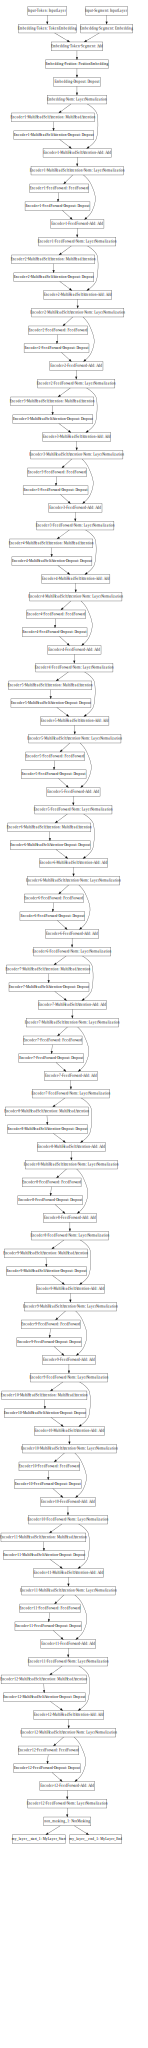

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(bert_model, dpi=65).create(prog='dot', format='svg'))

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

history = bert_model.fit(train_x, train_y, epochs = 25, batch_size=10, shuffle=False, verbose=1)

Epoch 1/25
60/60 [==============================] - 22s 374ms/step - loss: 12.5969 - my_layer__start_2_loss: 6.0774 - my_layer__end_2_loss: 6.5195 - my_layer__start_2_acc: 0.0667 - my_layer__end_2_acc: 0.1000
Epoch 2/25
60/60 [==============================] - 6s 102ms/step - loss: 10.6380 - my_layer__start_2_loss: 5.0815 - my_layer__end_2_loss: 5.5565 - my_layer__start_2_acc: 0.0833 - my_layer__end_2_acc: 0.1167
Epoch 3/25
60/60 [==============================] - 6s 103ms/step - loss: 8.5365 - my_layer__start_2_loss: 4.3827 - my_layer__end_2_loss: 4.1538 - my_layer__start_2_acc: 0.1333 - my_layer__end_2_acc: 0.1000
Epoch 4/25
60/60 [==============================] - 6s 103ms/step - loss: 6.4028 - my_layer__start_2_loss: 3.3622 - my_layer__end_2_loss: 3.0405 - my_layer__start_2_acc: 0.1167 - my_layer__end_2_acc: 0.1500
Epoch 5/25
60/60 [==============================] - 6s 104ms/step - loss: 4.6499 - my_layer__start_2_loss: 2.6049 - my_layer__end_2_loss: 2.0450 - my_layer__start_2_acc:

In [0]:
def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

In [0]:
def predict_letter(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

In [0]:
doc = '''3일동안 딥러닝에 집중해보자 !
잡힐듯 말듯한 딥러닝은 대체 뭔지..
딥러닝을 잘 쓰기 위해 필요한 이론과 실습,
2월엔, 딥러닝에 3일만 빠져보자!!
< 1차 딥러닝 : 2월   7 ~   9일 >
Day1: 빠르게 들여다보는 파이썬 머신러닝
    - 머신러닝과 딥러닝, 그 미묘한 차이
    - 파이썬 뽀개기 (기초문법, 웹 크롤링, 데이터 분석 및 시각화 실습)
Day2: 머신러닝과 딥러닝 뜯어보기
    - 놓치지 말아야 할 기본적인 머신러닝 알고리즘들
    - 쉽게 풀어 이해하는 딥러닝의 필수적인 개념들
    - 파이썬을 활용한 실습 (Scikit-learn / Keras)
Day3: 핫하다는 텐서플로로 딥러닝을
    - Tensorflow 기초
    - Tensorflow 로 시작하는 딥러닝 실습(Linear Regression & Neural Network 실습)
    - Tensorflow 를 활용한 데이터 분석 (CNN & RNN)
<  2차 딥러닝 : 2월 12 ~ 14일 >
Day1: 
     1. 인공지능의 이해
     2. 파이썬 역량강화 (Keras, Tensorflow)
     3. 머신러닝의 이해 및 실습 (지도 및 비지도 학습)
Day2:
     1. 딥러닝의 이해 - 동작원리부터 신경망
     2. 딥러닝의 이해 - 오차역전파에 대한 이해 및 RNN + LSTM
     3. 딥러닝 실습
Day3:
     1. 시각인지 기본개요 / CNN / 시각인지 실습
     2. GAN
     3. Reinforcement Learning 소개
* 시간과 수강료
   - 1차 : 20만원 - 2월 7~9일 (수목금) 총 24시간, 아침 10시부터 저녁 7시까지 하루 8시간씩
   - 1차 : 20만원 - 2월 12~14일 (월화수) 총 24시간, 20만원, 아침 10시부터 저녁 7시까지 하루 8시간씩
   - 1,2차 모두 신청시 30만원으로 할인
* 수료 혜택
   - 사단법인 한국인공지능협회에서 딥러닝 수업 수료증 발급
* 수강생 유의사항 : 
  - 노트북 지참 
* 장소: 1호선 신설동역 3번출구 남서울평생교육원 5층 510호 (후원: 남서울대 빅데이터보안학과)
  - 주차가 지원되지 않습니다.
* 입금계좌 : 국민은행 591501-04-060354 (예금주 사단법인 한국인공지능협회)
  - 신청 후 입금까지 해주셔야 확정이 됩니다. 마감은 입금 순입니다.
* 환불규정
  - 강의 시작전 100% 환불
  - 강의 1회 참석이후, 2/3 환불
  - 강의 2회 참석이후, 1/3 환불
* 문의 : 한국인공지능협회 AI 아카데미 ( 010 - 8079 - 2260 )
홈페이지 : (사) 한국인공지능협회 공식 사이트    https://www.koraia.org/'''


predict_letter("집중 딥러닝 강의장소가 어디야?", doc)

Question :  집중 딥러닝 강의장소가 어디야?
--------------------------------------------------
Context :  3일동안 딥러닝에 집중해보자 !
잡힐듯 말듯한 딥러닝은 대체 뭔지..
딥러닝을 잘 쓰기 위해 필요한 이론과 실습,
2월엔, 딥러닝에 3일만 빠져보자!!
< 1차 딥러닝 : 2월   7 ~   9일 >
Day1: 빠르게 들여다보는 파이썬 머신러닝
    - 머신러닝과 딥러닝, 그 미묘한 차이
    - 파이썬 뽀개기 (기초문법, 웹 크롤링, 데이터 분석 및 시각화 실습)
Day2: 머신러닝과 딥러닝 뜯어보기
    - 놓치지 말아야 할 기본적인 머신러닝 알고리즘들
    - 쉽게 풀어 이해하는 딥러닝의 필수적인 개념들
    - 파이썬을 활용한 실습 (Scikit-learn / Keras)
Day3: 핫하다는 텐서플로로 딥러닝을
    - Tensorflow 기초
    - Tensorflow 로 시작하는 딥러닝 실습(Linear Regression & Neural Network 실습)
    - Tensorflow 를 활용한 데이터 분석 (CNN & RNN)
<  2차 딥러닝 : 2월 12 ~ 14일 >
Day1: 
     1. 인공지능의 이해
     2. 파이썬 역량강화 (Keras, Tensorflow)
     3. 머신러닝의 이해 및 실습 (지도 및 비지도 학습)
Day2:
     1. 딥러닝의 이해 - 동작원리부터 신경망
     2. 딥러닝의 이해 - 오차역전파에 대한 이해 및 RNN + LSTM
     3. 딥러닝 실습
Day3:
     1. 시각인지 기본개요 / CNN / 시각인지 실습
     2. GAN
     3. Reinforcement Learning 소개
* 시간과 수강료
   - 1차 : 20만원 - 2월 7~9일 (수목금) 총 24시간, 아침 10시부터 저녁 7시까지 하루 8시간씩
   - 1차 : 20만원 - 2월 12~14일 (월화수) 총 24시간, 20만